In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
lya=1215.67

In [2]:
z_bin_centre = 2.25
z_bin_width = 0.2
z_bin = (z_bin_centre-z_bin_width/2,z_bin_centre+z_bin_width/2)
beta = 1.65
lambda_min = 3550.0

In [3]:
#Trim the skewers to a narrow window around the z value selected
#Get the growth factor and any other useful things
master = fits.open('/Users/jfarr/Projects/test_data/process_output_G_hZ_4096_32_sr2.0_bm1_nside16/nside_16_master.fits')
Z = master[2].data['Z']
lambdas = lya*(1+Z)
first_relevant_cell = np.argmax(lambdas>lambda_min)
D = master[2].data['D'][first_relevant_cell:]
Z = Z[first_relevant_cell:]

In [4]:
def lognormal_transform(delta_G_rows,sigma_G,D):
    density_rows = np.zeros(delta_G_rows.shape)
    for j in range(delta_G_rows.shape[1]):
        D_j = D[j]
        density_rows[:,j] = np.exp(D_j*delta_G_rows[:,j]-(D_j**2)*(sigma_G**2)/2.)
    return density_rows

In [5]:
def get_mean_F_model(z):
    return np.exp((np.log(0.8))*(((1+z)/3.25)**3.2))

In [6]:
def delta_G_to_delta_F(delta_G_rows,alpha,beta,D,sigma_G,IVAR_rows=None,mean_F=None):
    density_rows = lognormal_transform(delta_G_rows,sigma_G,D)
    F_rows = np.exp(-alpha*(density_rows**beta))
    if not mean_F:
        mean_F = np.average(F_rows,weights=IVAR_rows)
    delta_F_rows = F_rows/mean_F - 1
    return density_rows,F_rows,mean_F,delta_F_rows

In [7]:
def density_to_flux(density,alpha,beta):
    F = np.exp(-alpha*(density**beta))
    return F

In [8]:
def get_flux_stats(z,sigma_G,alpha,beta,mean_only=False,show_plot=False):

    int_lim_fac = 10.0
    int_lim = sigma_G*int_lim_fac
    
    delta_G_integral = np.linspace(-int_lim,int_lim,num=10**4)
    delta_G_integral = np.reshape(delta_G_integral,(1,delta_G_integral.shape[0]))
    
    D_value = D[np.argmax(Z>z_bin_centre)]
    D_integral = (D_value)*np.ones(delta_G_integral.shape[1])

    prob_delta_G = (1/((np.sqrt(2*np.pi))*sigma_G))*np.exp(-(delta_G_integral**2)/(2*(sigma_G**2)))
    
    density_integral = lognormal_transform(delta_G_integral,sigma_G,D_integral)
    F_integral = density_to_flux(density_integral,alpha,beta)
        
    mean_F = np.trapz(prob_delta_G*F_integral,delta_G_integral)[0]
    
    delta_F_integral = F_integral/mean_F - 1
    
    if mean_only == False:
        integrand = prob_delta_G*(delta_F_integral**2)
        sigma_F = np.sqrt(np.trapz(integrand,delta_G_integral)[0])
    else:
        sigma_F = None
    
    if show_plot == True:
        plt.scatter(delta_G_integral,prob_delta_G*F_integral,label='mean F')
        plt.scatter(delta_G_integral,prob_delta_G*(delta_F_integral**2),label='var F')
        plt.ylabel('integrand')
        plt.xlabel('delta_G')
        plt.title('alpha: {}'.format(alpha))
        plt.legend()
        plt.grid()
        plt.show()
    
    return mean_F, sigma_F

In [9]:
sigma_G_values = np.linspace(0.01,10.0,1000)
print('{} <= sigma_G <= {}'.format(np.min(sigma_G_values),np.max(sigma_G_values)))
print('{} values of sigma_G will be tested'.format(sigma_G_values.shape[0]))

0.01 <= sigma_G <= 10.0
1000 values of sigma_G will be tested


In [10]:
tolerances = [0.01,0.001,0.0001]

mean_F_model = get_mean_F_model(z_bin_centre)
print('mean F model {}\n'.format(mean_F_model))

results = np.zeros((len(tolerances),sigma_G_values.shape[0]))

for i,tolerance in enumerate(tolerances):
    print('looking at tolerance {}...'.format(tolerance))
    for j,sigma_G in enumerate(sigma_G_values):
        print('---> looking at sigma_G {:2.2f}...'.format(sigma_G),end='\r')
        alpha_low = 0.0
        alpha_high = 1000.0

        alpha_log_low = -3.
        alpha_log_high = 10

        count = 0
        exit = 0

        while exit == 0 and count < 30:
            alpha_midpoint = (alpha_low + alpha_high)/2.0
            alpha_log_midpoint = (alpha_log_low + alpha_log_high)/2.0
            """
            mean_F_al,sigma_F_al = get_flux_stats(z_bin_centre,sigma_G,alpha_low,beta,mean_only=True)
            mean_F_am,sigma_F_am = get_flux_stats(z_bin_centre,sigma_G,alpha_midpoint,beta,mean_only=True)
            mean_F_ah,sigma_F_ah = get_flux_stats(z_bin_centre,sigma_G,alpha_high,beta,mean_only=True)
            """
            mean_F_al,sigma_F_al = get_flux_stats(z_bin_centre,sigma_G,10**alpha_log_low,beta,mean_only=True)
            mean_F_am,sigma_F_am = get_flux_stats(z_bin_centre,sigma_G,10**alpha_log_midpoint,beta,mean_only=True)
            mean_F_ah,sigma_F_ah = get_flux_stats(z_bin_centre,sigma_G,10**alpha_log_high,beta,mean_only=True)

            #print('model: {:2.4f}, ({:2.2f},{:2.2f},{:2.2f}), ({:2.2f},{:2.2f},{:2.2f})'.format(mean_F_model,alpha_low,alpha_midpoint,alpha_high,mean_F_al,mean_F_am,mean_F_ah))
            if np.sign(mean_F_al-mean_F_model) * np.sign(mean_F_am-mean_F_model) > 0:
                alpha_low = alpha_midpoint
                alpha_log_low = alpha_log_midpoint
            else:
                alpha_high = alpha_midpoint
                alpha_log_high = alpha_log_midpoint

            if abs(mean_F_am/mean_F_model - 1) < tolerance:
                exit = 1
            else:
                count += 1

        alpha = alpha_midpoint
        alpha = 10**alpha_log_midpoint
        mean_F,sigma_F = get_flux_stats(z_bin_centre,sigma_G,alpha,beta)

        results[i,j] = sigma_F
        #print('sigma G {:2.2f}, alpha {:2.2f}: mean F {:2.4f}, sigma F {:2.4f}, n {:3d}'.format(sigma_G,alpha,mean_F,sigma_F,count))



mean F model 0.8

looking at tolerance 0.01...


/Users/jfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


/Users/jfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


looking at tolerance 0.001......
looking at tolerance 0.0001.....


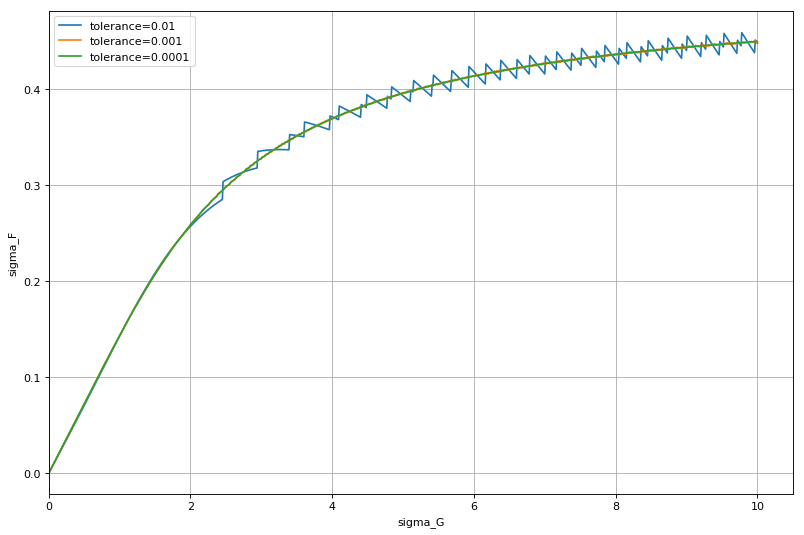

In [18]:
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
for i,tolerance in enumerate(tolerances):
    plt.plot(sigma_G_values,results[i,:],label='tolerance={}'.format(tolerances[i]))
plt.ylabel('sigma_F')
plt.xlabel('sigma_G')
plt.xlim(xmin=0.0)
plt.legend()
plt.grid()
plt.savefig('sigmaF_by_sigmaG_z{}.pdf'.format(z_bin_centre))
plt.show()

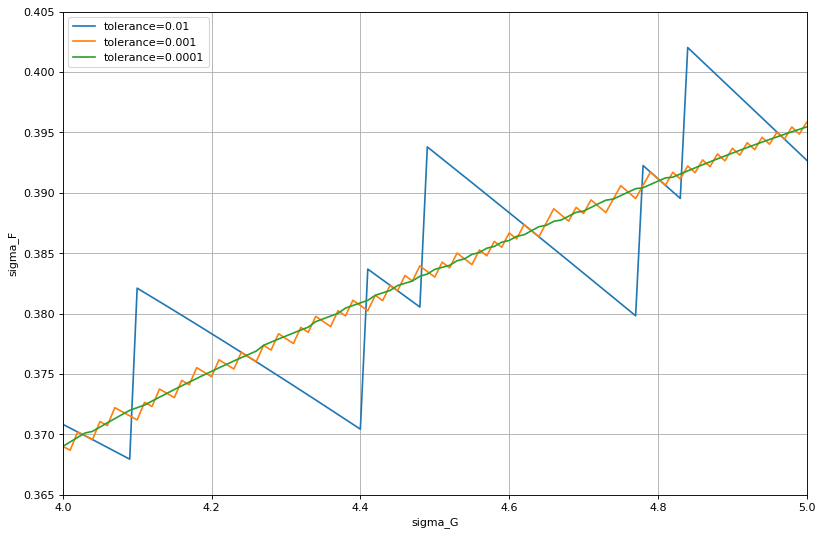

In [19]:
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
for i,tolerance in enumerate(tolerances):
    plt.plot(sigma_G_values,results[i,:],label='tolerance={}'.format(tolerances[i]))
plt.ylabel('sigma_F')
plt.xlabel('sigma_G')
plt.xlim(4,5)
plt.ylim(0.365,0.405)
plt.legend()
plt.grid()
plt.savefig('sigmaF_by_sigmaG_z{}_zoom.pdf'.format(z_bin_centre))
plt.show()

In [22]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

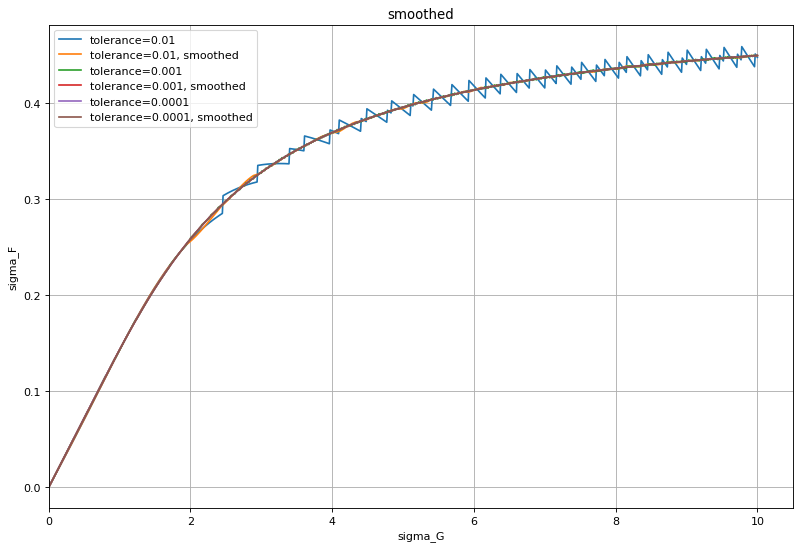

In [23]:
results_hat = np.zeros(results.shape)
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
for i in range(results.shape[0]):
    results_hat[i,:] = savitzky_golay(results[i,:], 101, 3)
    plt.plot(sigma_G_values,results[i,:],label='tolerance={}'.format(tolerances[i]))
    plt.plot(sigma_G_values,results_hat[i,:],label='tolerance={}, smoothed'.format(tolerances[i]))
plt.ylabel('sigma_F')
plt.xlabel('sigma_G')
plt.xlim(xmin=0.0)
plt.legend()
plt.grid()
plt.title('smoothed')
plt.savefig('sigmaF_by_sigmaG_z{}_smoothed.pdf'.format(z_bin_centre))
plt.show()

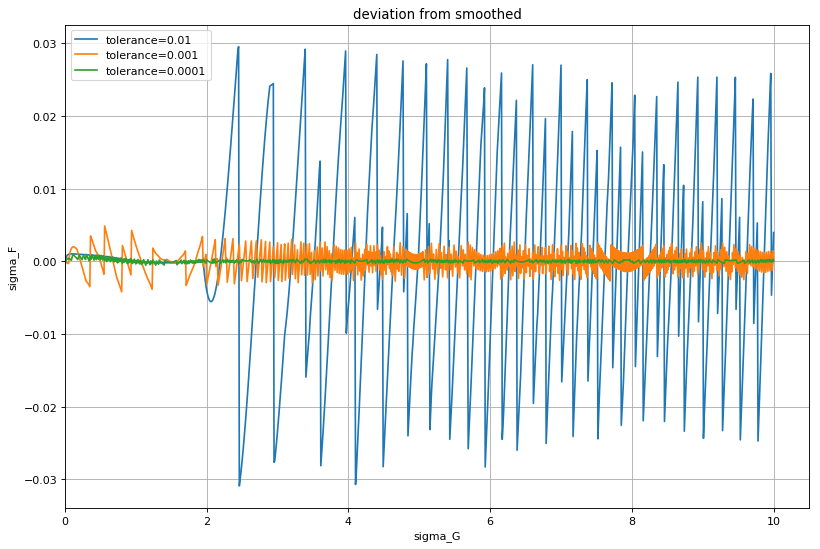

In [24]:
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
for i in range(results.shape[0]):
    plt.plot(sigma_G_values,results_hat[i,:]/results[i,:] -1,label='tolerance={}'.format(tolerances[i]))
plt.ylabel('sigma_F')
plt.xlabel('sigma_G')
plt.xlim(xmin=0.0)
plt.legend()
plt.grid()
plt.title('deviation from smoothed')
plt.savefig('sigmaF_by_sigmaG_z{}_smoothed_deviation.pdf'.format(z_bin_centre))
plt.show()

In [17]:
#Get the gaussian delta skewers
h = fits.open('/Users/James/Projects/test_data/process_output_G_hZ_4096_32_sr2.0_bm1_nside16/10/1064/picca-gaussian-16-1064.fits')
delta_G_rows = h[0].data.T
IVAR_rows = h[1].data.T
#delta_G_rows = delta_G_rows[0,:]


first_valid_cell = np.argmax(Z>z_bin[0])
last_valid_cell = np.argmax(Z>z_bin[1]) - 1
valid_rows = Z_QSO>z_bin[0]

D = D[first_valid_cell:last_valid_cell]
Z = Z[first_valid_cell:last_valid_cell]
delta_G_rows = delta_G_rows[:,first_valid_cell:last_valid_cell]
delta_G_rows = delta_G_rows[valid_rows,:]
IVAR_rows = IVAR_rows[:,first_valid_cell:last_valid_cell]
IVAR_rows = IVAR_rows[valid_rows,:]
Z_QSO = Z_QSO[valid_rows]

print('we have {} skewers, each with {} cells'.format(delta_G_rows.shape[0],delta_G_rows.shape[1]))
print('cells are in the z-range: {:2.2f} < z < {:2.2f}'.format(np.min(Z),np.max(Z)))

we have 7 skewers, each with 75 cells
cells are in the z-range: 2.15 < z < 2.35


check that the skewers aren't just empty:


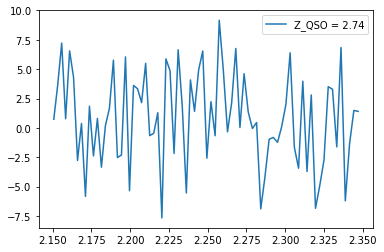

In [18]:
print('check that the skewers aren\'t just empty:')
n = np.random.randint(0,high=len(Z_QSO))
plt.plot(Z,delta_G_rows[n,:],label='Z_QSO = {:2.2f}'.format(Z_QSO[n]))
plt.legend()
plt.show()